In [91]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer
import functools

src_path = os.path.abspath(os.path.join('../src'))
if src_path not in sys.path:
    sys.path.append(src_path)
    
from utils.data import load_news, load_users
from utils.hydra import RunCollection
from evaluation.metrics import gs_score, ild


In [38]:
DATA_DIR = "../data"
MIN_HISTORY_LENGTH = 3

In [39]:
runs = RunCollection.from_path("../outputs")
runs = runs.filter_by_job("train_embeddings")
run = runs.one()
run.show_config()

seed: 515
epochs: 10
embedding_dim: 100
batch_size: 128
learning_rate: 0.001
n_negative_samples: 4
data:
  seed: 468
  num_users: 200000
  source: large
  target: ${data.num_users}_${data.seed}
  mind_variant: ${data.target}



In [40]:
metrics = pd.read_csv(run.get_file_path("metrics.csv"))
metrics

,P@1,P@5,MRR,FMI,Silhouette,Train loss,epoch
0,0.000,0.000,0.073282,0.287594,0.297637,0.903918,0
1,0.000,0.500,0.172520,0.284227,0.413630,0.438126,1
2,0.000,0.500,0.209265,0.283156,0.444662,0.414427,2
3,0.125,0.750,0.339576,0.278538,0.455532,0.397396,3
4,0.000,0.625,0.219583,0.280536,0.457033,0.385194,4
5,0.000,0.500,0.203013,0.275973,0.463143,0.374783,5
6,0.000,0.500,0.196939,0.274677,0.446814,0.365187,6
7,0.000,0.500,0.193173,0.271252,0.438696,0.356269,7
8,0.000,0.500,0.173803,0.266217,0.423577,0.347888,8
9,0.000,0.375,0.167285,0.266011,0.419336,0.340088,9


In [41]:
best_epoch = int(metrics.iloc[metrics["P@5"].idxmax()]["epoch"])
print(f"Using topic embeddings from epoch {best_epoch}")
topic_embeddings_path = run.get_file_path(f"topic_embeddings_{best_epoch}.feather")
topic_embeddings = pd.read_feather(topic_embeddings_path)
topic_embeddings

Using topic embeddings from epoch 3


,subcategory,embedding
0,ads-latingrammys,"[-0.5279844, 1.2566609, 0.09642819, -0.2321693..."
1,ads-lung-health,"[0.07290848, -0.108872466, -0.116296835, 0.058..."
2,advice,"[-0.07572569, -0.05586439, -0.103811264, -0.10..."
3,animals,"[0.114049695, -0.09510901, -0.15006417, -0.116..."
4,autosbuying,"[0.012851537, 0.12294536, -0.030278068, 0.0524..."
...,...,...
249,weightloss,"[-0.075820275, -1.4854307e-05, 0.16013281, -0...."
250,wellness,"[-0.018470695, -0.04485918, 0.08147979, -0.051..."
251,wines,"[-1.0180085, -0.6784834, -0.5070956, -0.352719..."
252,wonder,"[0.11814448, -0.012971732, -0.12646337, -0.029..."


In [42]:
mind_variant = run.config.data.mind_variant
news = load_news(mind_variant, columns=["category", "subcategory", "title"], data_dir=DATA_DIR)
news = news.drop(columns="split")
news

,category,subcategory,title
id,,,
N88753,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an..."
N23144,health,weightloss,50 Worst Habits For Belly Fat
N86255,health,medical,Dispose of unwanted prescription drugs during ...
N93187,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...
N75236,health,voices,I Was An NBA Wife. Here's How It Affected My M...
...,...,...,...
N29497,video,peopleandplaces,You might be in a police lineup right now and ...
N55370,sports,football_nfl,Devin McCourty on D&K: N'Keal Harry upsets Pat...
N54303,sports,baseball_mlb,Yankees prospect Clarke Schmidt is quickly on ...


In [43]:
categories_in_news = set(news["subcategory"])
categories_in_embeddings = set(topic_embeddings["subcategory"])
missing_categories = categories_in_news.difference(categories_in_embeddings)
missing_categories = pd.DataFrame(missing_categories, columns=["subcategory"])
print("Missing categories:")
news\
    .merge(missing_categories, on="subcategory")\
    .groupby("subcategory")\
    .count()\
    .reset_index()\
    .rename(columns={"category": "n_articles"})

Missing categories:


,subcategory,n_articles,title
0,autoslosangeles,1,1
1,autosmidsize,1,1
2,basketball,1,1
3,cardio,1,1
4,causes-poverty,1,1
5,entertainmentmusic,1,1
6,entertainmenttv,1,1
7,finance-startinvesting,1,1
8,foodanddrink,1,1
9,halloween,1,1


In [44]:
news_with_embeddings = news.reset_index().merge(topic_embeddings, on="subcategory")
n_excluded_news = len(news) - len(news_with_embeddings)
news = news_with_embeddings
news = news.rename(columns={'embedding': 'topic_embedding'})
news = news.set_index("id")
news

,category,subcategory,title,topic_embedding
id,,,,
N88753,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","[-0.05900184, -0.11635385, 0.0978779, -0.09877..."
N81543,lifestyle,lifestyleroyals,Kate Middleton's Best Hairstyles Through the Y...,"[-0.05900184, -0.11635385, 0.0978779, -0.09877..."
N71593,lifestyle,lifestyleroyals,Every outfit Duchess Kate has worn in 2019,"[-0.05900184, -0.11635385, 0.0978779, -0.09877..."
N33576,lifestyle,lifestyleroyals,25 Photos of the Royal Family at Balmoral Cast...,"[-0.05900184, -0.11635385, 0.0978779, -0.09877..."
N115791,lifestyle,lifestyleroyals,Prince George's Royal Life in Photos,"[-0.05900184, -0.11635385, 0.0978779, -0.09877..."
...,...,...,...,...
N99911,autos,autosconvertibles,2020 Chevrolet Corvette C8 Convertible Price S...,"[1.8388319, 1.0420269, 0.40700355, 0.23218808,..."
N61853,sports,olympics-videos,NBA head to travel to China amid flap over pro...,"[-0.3969354, -0.6827047, -1.0807043, -0.829718..."
N70030,video,healthandfitness,What does Alzheimer's do to the human brain?,"[-1.3226296, 0.03540926, -0.8963475, 1.3719544..."


In [46]:
pretrained_model_name = "all-distilroberta-v1"
model = SentenceTransformer(pretrained_model_name)
title_embeddings = model.encode(news["title"], show_progress_bar=True, convert_to_numpy=True)
news["title_embedding"] = list(title_embeddings)

Batches:   0%|          | 0/2456 [00:00<?, ?it/s]

In [47]:
users = load_users(mind_variant, data_dir=DATA_DIR)
users = users.drop(columns="split")
users

,history
user,
U224919,"[N69106, N87211, N71082, N47193, N13423, N4926..."
U674332,"[N67489, N58992, N127780, N25818, N116152, N75..."
U174429,"[N90578, N11210, N128909, N44451, N97475, N123..."
U337966,"[N107906, N113326, N16824, N125021, N31493, N2..."
U477175,"[N95287, N7154, N43428, N44660, N72579, N12649..."
...,...
U717179,"[N9375, N85428, N94639, N72571, N60165, N11636..."
U720817,"[N2232, N121551, N117814, N31538, N34374, N506..."
U720724,"[N7742, N88765, N102525, N92733, N3560, N12896..."


In [93]:
reading_history = users.explode("history")
reading_history = reading_history.merge(news, left_on="history", right_index=True)
user_reads = reading_history.groupby("user")

embeddings = ["topic", "title"]
scoring_methods = {
    "gs": gs_score,
    "ild_cosine": ild,
    "ild_euclidean": functools.partial(ild, distance_metric="euclidean")
}

for embedding in embeddings:
    for scoring_method, scoring_fn in scoring_methods.items():
        key = f"{embedding}_{scoring_method}"
        users[key] = user_reads.apply(lambda x: scoring_fn(list(x[f"{embedding}_embedding"].values)) if len(x) > 1 else None)

users

,history,topic_gs,title_gs,history_length,topic_ild,title_ild,topic_ild_cosine,topic_ild_euclidean,title_ild_cosine,title_ild_euclidean
user,,,,,,,,,,
U224919,"[N69106, N87211, N71082, N47193, N13423, N4926...",0.589082,0.334976,21,0.677881,0.932180,0.677881,0.734921,0.932180,1.360321
U674332,"[N67489, N58992, N127780, N25818, N116152, N75...",0.575271,0.384582,12,0.720007,0.929560,0.720007,0.636155,0.929560,1.361928
U174429,"[N90578, N11210, N128909, N44451, N97475, N123...",0.580160,0.376884,25,0.684996,0.893707,0.684996,0.666857,0.893707,1.333650
U337966,"[N107906, N113326, N16824, N125021, N31493, N2...",0.532902,0.285520,130,0.718834,0.925598,0.718834,0.631707,0.925598,1.358343
U477175,"[N95287, N7154, N43428, N44660, N72579, N12649...",0.561256,0.464579,7,0.780796,0.914861,0.780796,0.583947,0.914861,1.339488
...,...,...,...,...,...,...,...,...,...,...
U717179,"[N9375, N85428, N94639, N72571, N60165, N11636...",0.458449,0.389971,10,0.873235,0.942136,0.873235,0.829599,0.942136,1.369264
U720817,"[N2232, N121551, N117814, N31538, N34374, N506...",0.498948,0.448365,7,0.868704,0.932130,0.868704,0.792549,0.932130,1.363252
U720724,"[N7742, N88765, N102525, N92733, N3560, N12896...",0.693388,0.380790,16,0.550652,0.911999,0.550652,0.453077,0.911999,1.347540


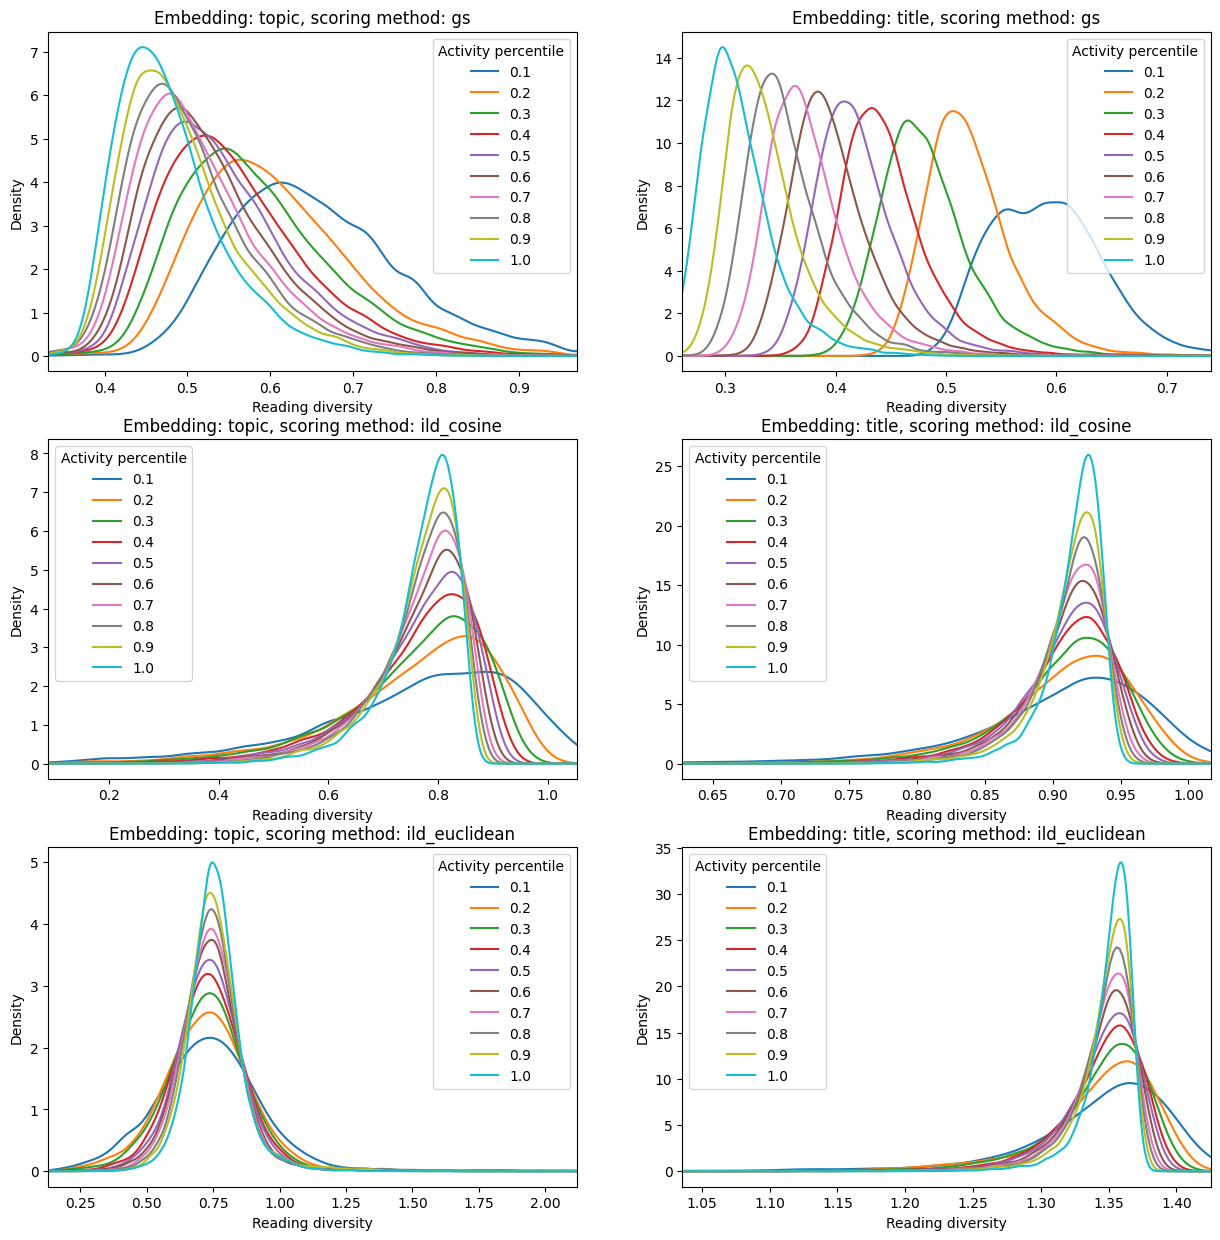

In [116]:
users["history_length"] = users["history"].apply(len)
included_users = users[users["history_length"] >= MIN_HISTORY_LENGTH].copy()

included_users["activity_percentile"] = pd.qcut(
    included_users.history_length, np.linspace(0, 1, 11), labels=np.arange(1, 11)/10
)

activity_percentiles = included_users.groupby("activity_percentile")

cutoff = 0.002

fig, axs = plt.subplots(3, 2, figsize=(15, 15))
for col, embedding in enumerate(embeddings):
    for row, scoring_method in enumerate(scoring_methods):
        key = f"{embedding}_{scoring_method}"
        ax = axs[row, col]
        ax.set_xlim((included_users[key].quantile(cutoff), included_users[key].quantile(1-cutoff)))
        ax.set_xlabel("Reading diversity")
        ax.set_title(f"Embedding: {embedding}, scoring method: {scoring_method}")
        for label, df in activity_percentiles:
            df[key].plot(kind="kde", ax=ax, label=label)
        legend = ax.legend()
        legend.set_title("Activity percentile")
